## Tweet Sentiment Analysis

### Data Loading and EDA

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balakumaransivarajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Step 2: Load the dataset
df = pd.read_csv('archive/train.csv', encoding='latin-1')
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
df.shape

(27481, 10)

In [4]:
# Step 2: Basic information about the dataset
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB
None


In [5]:
print("\nDataset Description:")
print(df.describe(include='all'))


Dataset Description:
            textID                                  text selected_text  \
count        27481                                 27480         27480   
unique       27481                                 27480         22430   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   
mean           NaN                                   NaN           NaN   
std            NaN                                   NaN           NaN   
min            NaN                                   NaN           NaN   
25%            NaN                                   NaN           NaN   
50%            NaN                                   NaN           NaN   
75%            NaN                                   NaN           NaN   
max            NaN                                   NaN           NaN   

       sentiment Time of Tweet Age of User      Country  Population -2020  \
count      2

In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


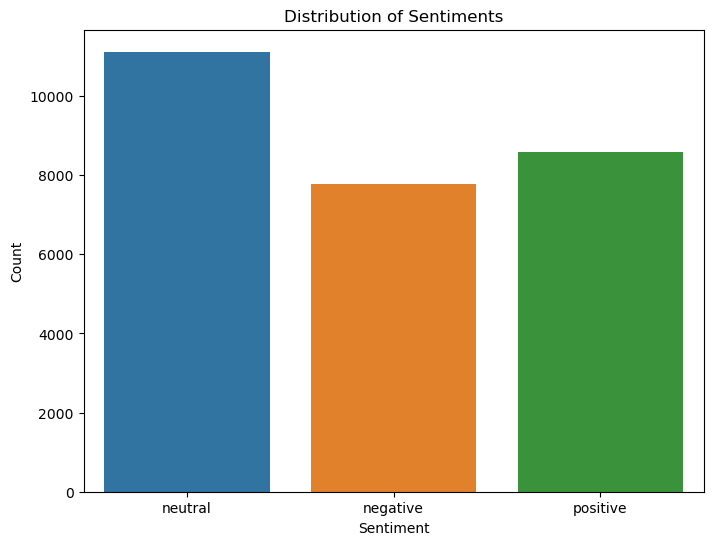

In [7]:
#Distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

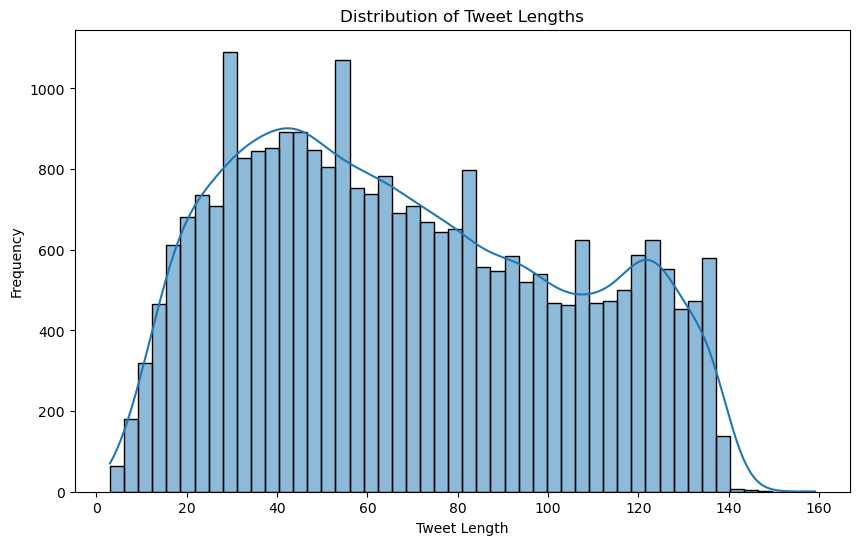

In [8]:
# Distribution of tweet lengths
df['text_length'] = df['text'].astype(str).apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

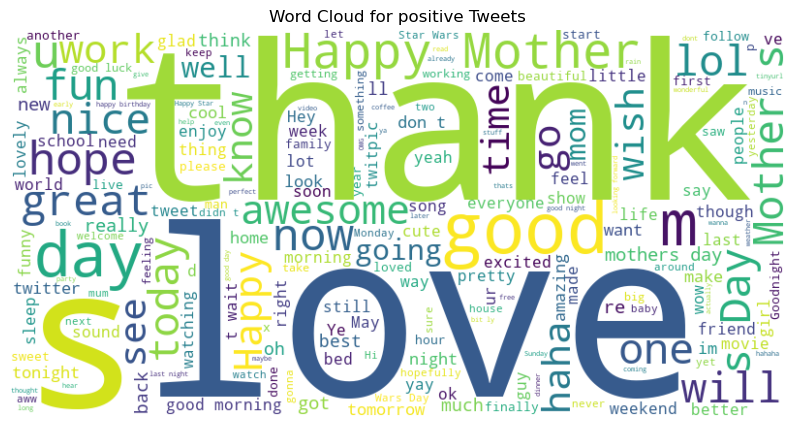

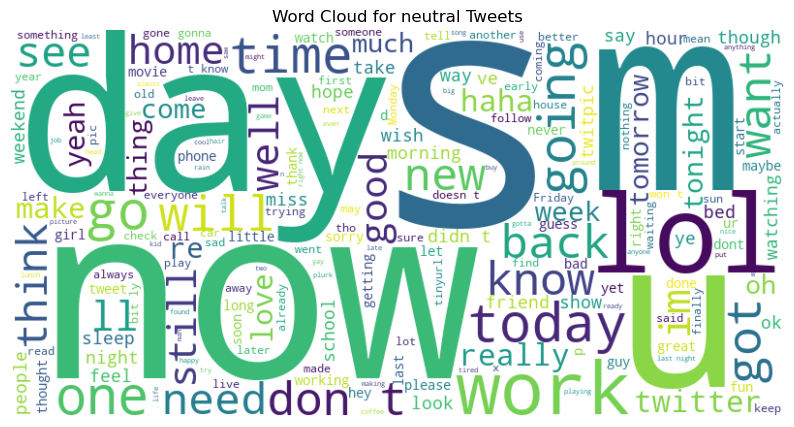

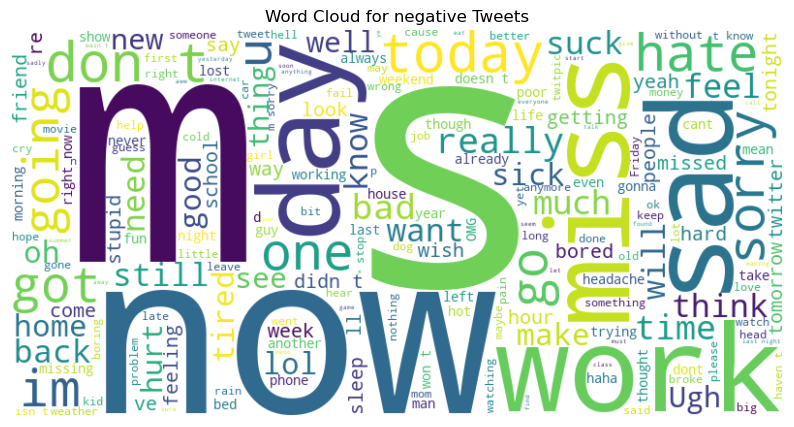

In [9]:
# Word Cloud for each sentiment
def plot_wordcloud(sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Tweets')
    plt.show()

plot_wordcloud('positive')
plot_wordcloud('neutral')
plot_wordcloud('negative')

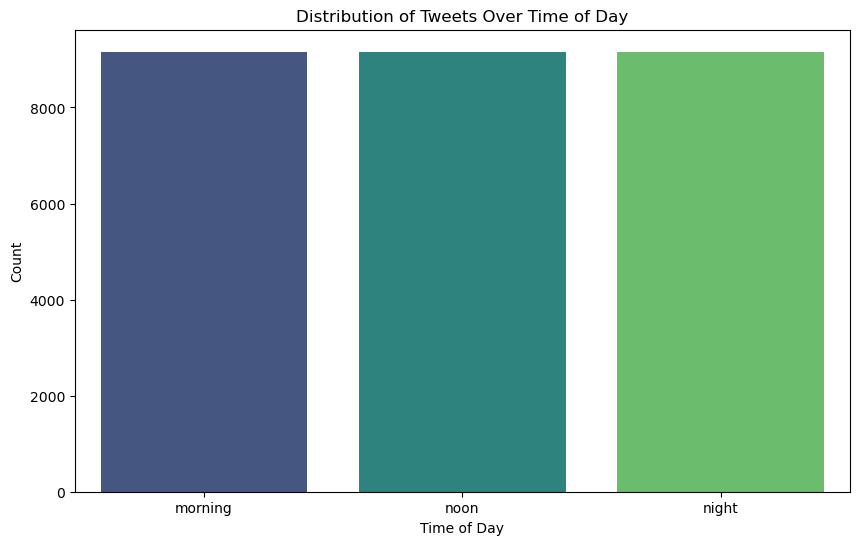

In [10]:
# Distribution of tweets over time of day
plt.figure(figsize=(10, 6))
sns.countplot(x='Time of Tweet', data=df, palette='viridis')
plt.title('Distribution of Tweets Over Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.show()

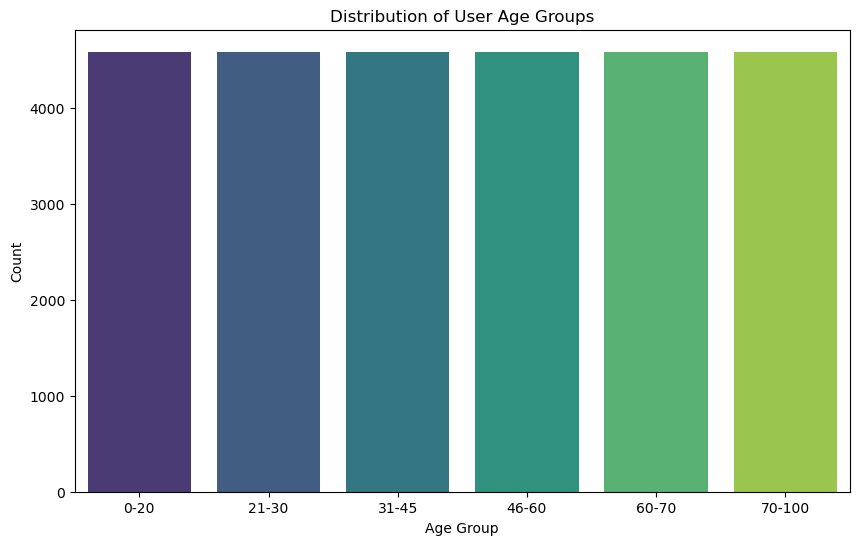

In [11]:
# Distribution of user age groups
plt.figure(figsize=(10, 6))
sns.countplot(x='Age of User', data=df, palette='viridis')
plt.title('Distribution of User Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

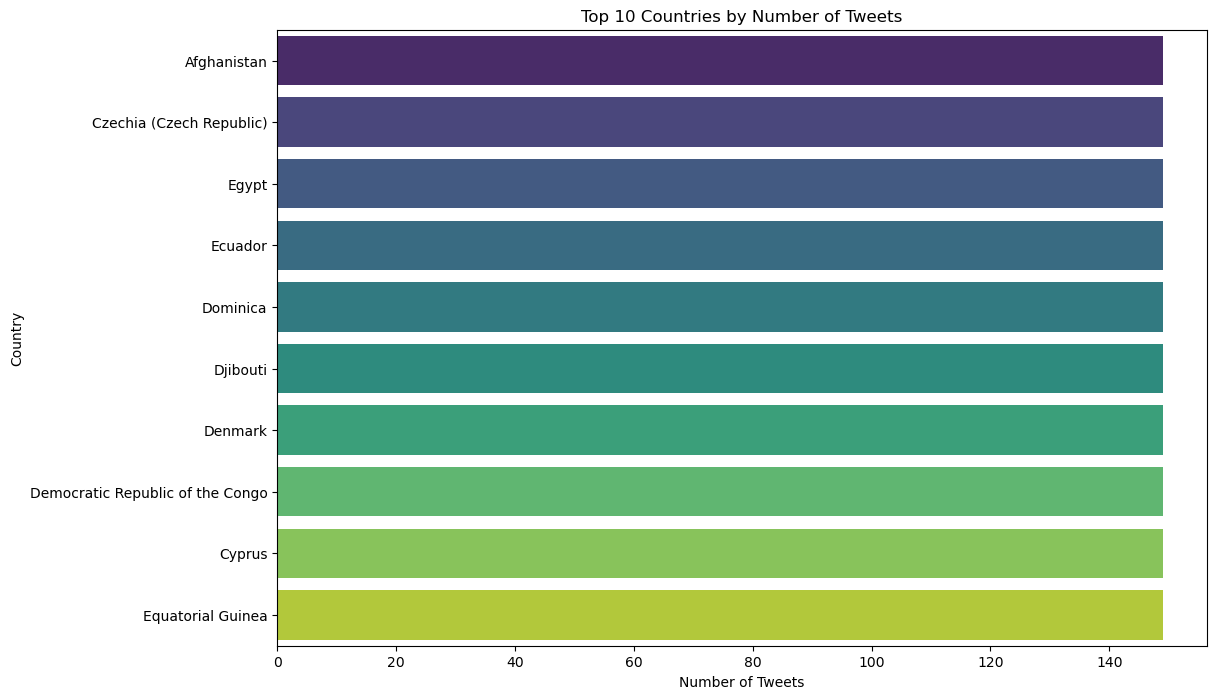

In [12]:
# Top countries by number of tweets
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries by Number of Tweets')
plt.xlabel('Number of Tweets')
plt.ylabel('Country')
plt.show()

### Data preprocessing

In [13]:
# Step 3: Data preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    text = text.replace("[^a-zA-Z]", " ")
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

### Feature extraction

In [14]:
# Step 4: Feature extraction
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['cleaned_text']).toarray()

# Combine text features with additional features
additional_features = df[['Time of Tweet', 'Age of User', 'Country']]

# Encoding categorical features
additional_features = pd.get_dummies(additional_features)

# Combine TF-IDF features with additional features
import numpy as np
X = np.hstack((X_text, additional_features.values))
y = df['sentiment'].apply(lambda x: 0 if x == 'negative' else (2 if x == 'neutral' else 4))

In [15]:
# Step 5: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Step 6: Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 7: Model evaluation
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Step 8: Save the model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Accuracy: 0.6860105512097507
              precision    recall  f1-score   support

           0       0.73      0.59      0.65      1562
           2       0.62      0.75      0.68      2230
           4       0.76      0.70      0.73      1705

    accuracy                           0.69      5497
   macro avg       0.70      0.68      0.69      5497
weighted avg       0.70      0.69      0.69      5497



['tfidf_vectorizer.pkl']

### Model Evaluation

In [19]:
# Step 7: Model evaluation
y_pred = best_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Step 8: Save the model and vectorizer
joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Accuracy: 0.682372203019829
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      1562
           2       0.63      0.71      0.67      2230
           4       0.75      0.72      0.73      1705

    accuracy                           0.68      5497
   macro avg       0.69      0.68      0.68      5497
weighted avg       0.69      0.68      0.68      5497



['tfidf_vectorizer.pkl']

The sentiment analysis model achieves 68% accuracy, with higher precision and recall for positive tweets. Performance is moderate for neutral and negative sentiments, indicating room for improvement. Enhancing preprocessing, feature engineering, and model tuning could help achieve better sentiment classification and overall model performance.